<a href="https://colab.research.google.com/github/betinaschilling/fiap-data-analytics/blob/main/causal_varejo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Causal no Varejo usando Redes Bayesianas

> pgmpy is a Python package for causal inference and probabilistic inference using Directed Acyclic Graphs (DAGs) and Bayesian Networks with a focus on modularity and extensibility. Implementations of various algorithms for Causal Discovery (a.k.a, Structure Learning), Parameter Estimation, Approximate (Sampling Based) and Exact inference, and Causal Inference are available.

* https://pgmpy.org/started/install.html

## Setup Inicial
Primeiro, vamos instalar e importar as bibliotecas necessárias:

In [ ]:
!pip install pgmpy networkx -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

## Gerando Dados Sintéticos para Demonstração


In [ ]:
np.random.seed(42)
n_samples = 1000

In [ ]:
# Variável de confusão: Sazonalidade (1 = alta temporada, 0 = baixa temporada)
sazonalidade = np.random.binomial(n=1, p=0.3, size=n_samples)
sazonalidade[:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
# Promoção (influenciada pela sazonalidade)
prob_promocao = np.where(sazonalidade == 1, 0.7, 0.3)
promocao = np.random.binomial(n=1, p=prob_promocao, size=n_samples)
promocao[:20]

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
# Nível de estoque (influenciado pela sazonalidade)
base_estoque = np.random.normal(loc=100, scale=20, size=n_samples)
estoque = base_estoque + sazonalidade * 50
estoque[:20]

array([ 88.06051427,  52.19391265, 141.7555851 , 118.26947464,
       110.75259806, 158.56372496,  94.40013396, 124.41938528,
       110.30588643,  83.3143638 , 143.68193467, 111.41014417,
       138.38703395,  87.77229505,  98.14111587,  95.20996156,
       122.33667551, 153.72832339,  85.36736522, 137.8088137 ])

In [ ]:
# Vendas (influenciadas por todos os fatores anteriores)
vendas_base = np.random.normal(loc=50, scale=10, size=n_samples)
vendas = (vendas_base +
         promocao * 30 +
         sazonalidade * 40 +
         np.clip(estoque, 0, 100) * 0.2)
vendas[:20]

array([ 68.44042856,  83.15706352, 127.48137069,  80.4006182 ,
        62.60228836, 126.65389393,  65.02330048, 144.34502646,
        72.40205844,  79.19420101,  77.89919722,  79.69569026,
       143.26855401,  53.66147171,  67.67123786,  79.64288971,
        99.48477071, 115.03090369,  63.88598989,  59.70188151])

In [ ]:
# Criando o DataFrame
data = pd.DataFrame({
    'sazonalidade': sazonalidade,
    'promocao': promocao,
    'estoque': estoque,
    'vendas': vendas
})

data.sample(10)

,sazonalidade,promocao,estoque,vendas
995,1,0,174.599807,94.193961
572,0,0,96.441642,81.243642
735,1,1,172.116661,153.451476
624,0,1,117.049373,110.877104
378,0,0,99.602527,72.153315
133,0,0,102.262809,71.007911
391,0,0,103.988480,81.933110
101,0,0,105.992954,61.871764
29,0,0,77.954605,64.780461
388,1,1,163.627247,134.612392


In [ ]:
# Discretização das variáveis contínuas
data['estoque_cat'] = pd.qcut(data['estoque'], q=3, labels=['baixo', 'medio', 'alto'])
data['vendas_cat'] = pd.qcut(data['vendas'], q=3, labels=['baixas', 'medias', 'altas'])

In [ ]:
# Convertendo para strings (requisito do pgmpy)
for col in ['sazonalidade', 'promocao', 'estoque_cat', 'vendas_cat']:
    data[col] = data[col].astype(str)

## Criando a Rede Bayesiana


In [ ]:
# Definindo a estrutura da rede
model = BayesianNetwork([
    ('sazonalidade', 'promocao'),        # Sazonalidade influencia decisões de promoção
    ('sazonalidade', 'estoque_cat'),     # Sazonalidade influencia níveis de estoque
    ('promocao', 'vendas_cat'),          # Promoções impactam vendas
    ('estoque_cat', 'vendas_cat'),       # Nível de estoque afeta vendas
    ('sazonalidade', 'vendas_cat')       # Sazonalidade tem efeito direto nas vendas
])

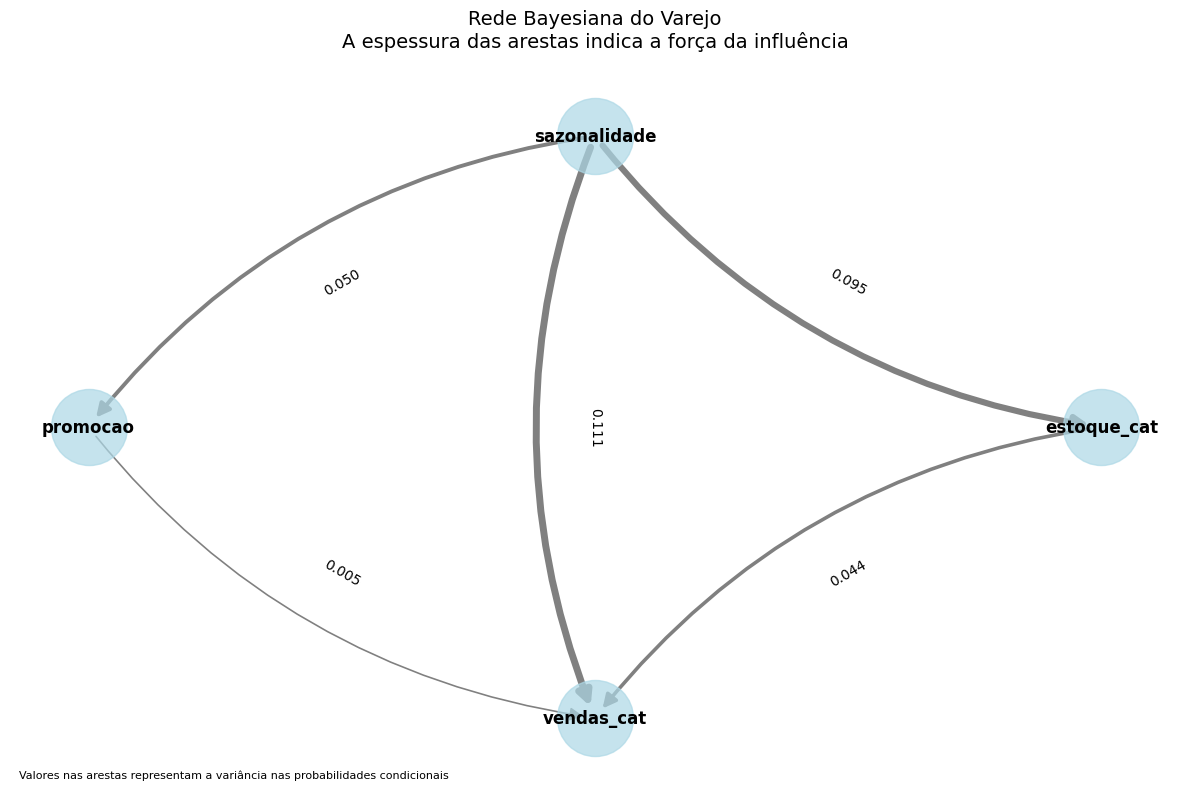

In [ ]:
def calculate_influence(model, from_node, to_node):
    """Calcula a força da influência entre dois nós baseado nas CPDs"""
    cpd = model.get_cpds(to_node)
    values = cpd.values
    evidence = cpd.get_evidence()

    if evidence and from_node in evidence:
        # Encontra o índice da variável de interesse
        evidence_idx = evidence.index(from_node)

        # Calcula a diferença média nas probabilidades
        if len(values.shape) > 1:
            # Calculando a variação média ao longo do eixo da evidência
            variance = np.var(values, axis=evidence_idx)
            return float(np.mean(variance))
    return 0.1  # valor base para quando não há influência direta

def plot_network_with_influence(model):
    plt.figure(figsize=(12, 8))
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    # Layout manual
    pos = {
        'sazonalidade': (0, 1),
        'promocao': (-1, 0),
        'estoque_cat': (1, 0),
        'vendas_cat': (0, -1)
    }

    # Calculando influências
    edge_weights = {}
    for edge in G.edges():
        influence = calculate_influence(model, edge[0], edge[1])
        edge_weights[edge] = influence

    # Normalizando os pesos para espessura das linhas
    max_weight = max(edge_weights.values())
    normalized_weights = {k: (v/max_weight * 4 + 1) for k, v in edge_weights.items()}

    # Desenhando nós
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=3000,
                          alpha=0.7)

    # Desenhando arestas com espessuras diferentes
    for edge in G.edges():
        nx.draw_networkx_edges(G, pos,
                             edgelist=[edge],
                             width=normalized_weights[edge],
                             edge_color='gray',
                             arrows=True,
                             arrowsize=20,
                             connectionstyle='arc3,rad=0.2')

    # Adicionando labels dos nós
    labels = nx.draw_networkx_labels(G, pos,
                                   font_size=12,
                                   font_weight='bold')

    # Adicionando labels das arestas (influências)
    edge_labels = {edge: f'{edge_weights[edge]:.3f}' for edge in G.edges()}
    nx.draw_networkx_edge_labels(G, pos,
                                edge_labels=edge_labels,
                                font_size=10,
                                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    # Adicionando legenda
    plt.title("Rede Bayesiana do Varejo\nA espessura das arestas indica a força da influência",
             pad=20, fontsize=14)

    # Adiciona uma nota explicativa
    plt.figtext(0.02, 0.02,
                "Valores nas arestas representam a variância nas probabilidades condicionais",
                fontsize=8, ha='left')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_network_with_influence(model)

In [ ]:
# Estimando as probabilidades condicionais
emv = MaximumLikelihoodEstimator(model=model, data=data)

In [ ]:
# Aprendendo os CPDs (Conditional Probability Distributions)
cpds = []
for node in model.nodes():
    cpd = emv.estimate_cpd(node)
    model.add_cpds(cpd)
    cpds.append(cpd)

## Análise de Probabilidades Condicionais


In [ ]:
def print_cpd(model, node):
    """Imprime a tabela de probabilidade condicional para um nó"""
    cpd = model.get_cpds(node)
    print(f"\nProbabilidades condicionais para {node}:")
    print(cpd)

# Imprimindo CPDs para todos os nós
for node in model.nodes():
    print_cpd(model, node)


Probabilidades condicionais para sazonalidade:
+-----------------+-------+
| sazonalidade(0) | 0.689 |
+-----------------+-------+
| sazonalidade(1) | 0.311 |
+-----------------+-------+

Probabilidades condicionais para promocao:
+--------------+--------------------+--------------------+
| sazonalidade | sazonalidade(0)    | sazonalidade(1)    |
+--------------+--------------------+--------------------+
| promocao(0)  | 0.706821480406386  | 0.2604501607717042 |
+--------------+--------------------+--------------------+
| promocao(1)  | 0.2931785195936139 | 0.7395498392282959 |
+--------------+--------------------+--------------------+

Probabilidades condicionais para estoque_cat:
+--------------------+---------------------+----------------------+
| sazonalidade       | sazonalidade(0)     | sazonalidade(1)      |
+--------------------+---------------------+----------------------+
| estoque_cat(alto)  | 0.08127721335268505 | 0.8938906752411575   |
+--------------------+--------------

## Análise de Cenários com Inferência

In [ ]:
from pgmpy.inference import VariableElimination

# Criando o modelo de inferência
inference = VariableElimination(model)

In [ ]:
def simular_cenario(evidencias):
    """
    Simula um cenário específico na rede Bayesiana

    Args:
        evidencias (dict): Dicionário com as evidências do cenário

    Returns:
        Probabilidades previstas para as vendas
    """
    return inference.query(variables=['vendas_cat'], evidence=evidencias)

In [ ]:
print("\nCenário Otimista (Alta temporada, Com promoção, Estoque alto):")
cenario_otimista = {
    'sazonalidade': '1',
    'promocao': '1',
    'estoque_cat': 'alto'
}
print(simular_cenario(cenario_otimista))


Cenário Otimista (Alta temporada, Com promoção, Estoque alto):
+--------------------+-------------------+
| vendas_cat         |   phi(vendas_cat) |
+====================+===================+
| vendas_cat(altas)  |            1.0000 |
+--------------------+-------------------+
| vendas_cat(baixas) |            0.0000 |
+--------------------+-------------------+
| vendas_cat(medias) |            0.0000 |
+--------------------+-------------------+


In [ ]:
print("\nCenário Pessimista (Baixa temporada, Sem promoção, Estoque baixo):")
cenario_pessimista = {
    'sazonalidade': '0',
    'promocao': '0',
    'estoque_cat': 'baixo'
}
print(simular_cenario(cenario_pessimista))


Cenário Pessimista (Baixa temporada, Sem promoção, Estoque baixo):
+--------------------+-------------------+
| vendas_cat         |   phi(vendas_cat) |
+====================+===================+
| vendas_cat(altas)  |            0.0000 |
+--------------------+-------------------+
| vendas_cat(baixas) |            0.7085 |
+--------------------+-------------------+
| vendas_cat(medias) |            0.2915 |
+--------------------+-------------------+


## Análise do Efeito Confundidor

In [ ]:
def analisar_efeito_confundidor():
    # Análise sem controlar pela sazonalidade
    prob_vendas_promocao = inference.query(
        variables=['vendas_cat'],
        evidence={'promocao': '1'}
    )

    print("\nProbabilidade de vendas dado promoção (sem controlar sazonalidade):")
    print(prob_vendas_promocao)

    # Análise controlando pela sazonalidade
    for saz in ['0', '1']:
        prob_vendas_promocao_saz = inference.query(
            variables=['vendas_cat'],
            evidence={'promocao': '1', 'sazonalidade': saz}
        )
        print(f"\nProbabilidade de vendas dado promoção e sazonalidade={saz}:")
        print(prob_vendas_promocao_saz)

analisar_efeito_confundidor()


Probabilidade de vendas dado promoção (sem controlar sazonalidade):
+--------------------+-------------------+
| vendas_cat         |   phi(vendas_cat) |
+====================+===================+
| vendas_cat(altas)  |            0.6503 |
+--------------------+-------------------+
| vendas_cat(baixas) |            0.0047 |
+--------------------+-------------------+
| vendas_cat(medias) |            0.3450 |
+--------------------+-------------------+

Probabilidade de vendas dado promoção e sazonalidade=0:
+--------------------+-------------------+
| vendas_cat         |   phi(vendas_cat) |
+====================+===================+
| vendas_cat(altas)  |            0.2522 |
+--------------------+-------------------+
| vendas_cat(baixas) |            0.0100 |
+--------------------+-------------------+
| vendas_cat(medias) |            0.7378 |
+--------------------+-------------------+

Probabilidade de vendas dado promoção e sazonalidade=1:
+--------------------+-------------------+


## Plots

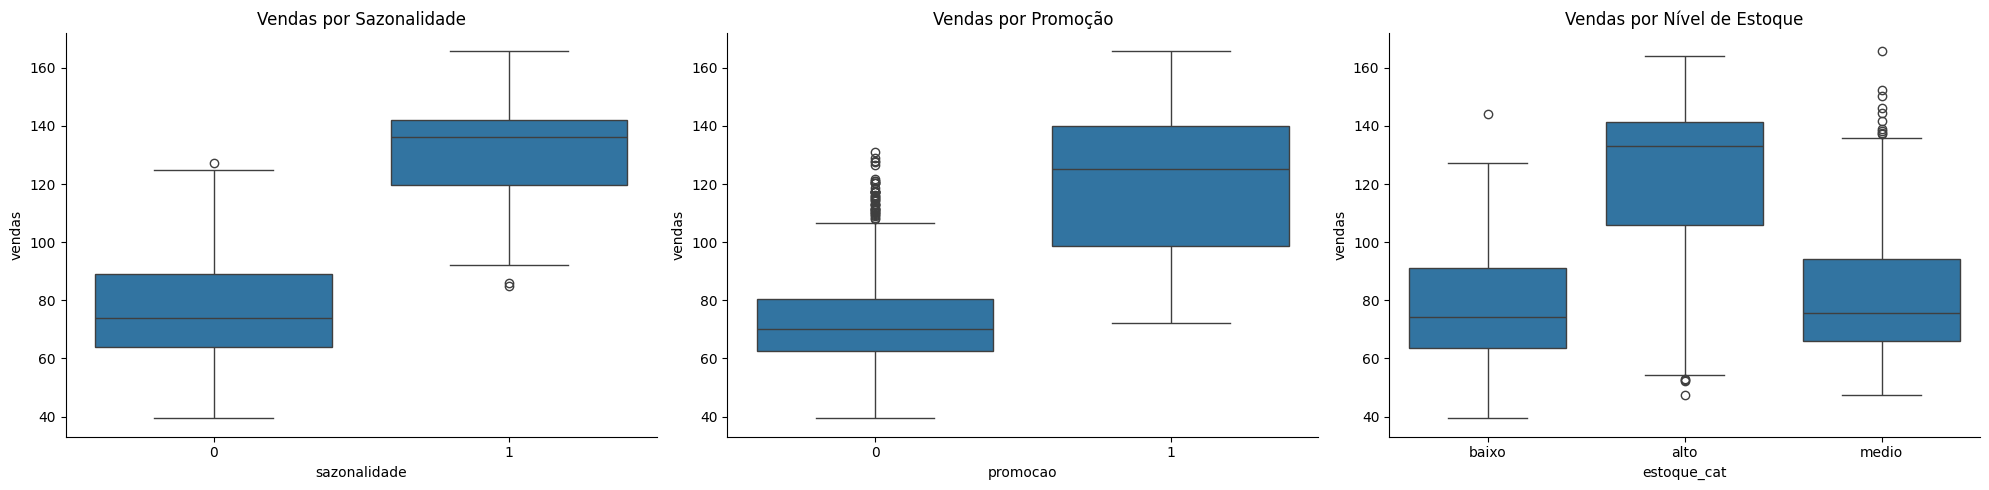

In [ ]:
def plot_conditional_distributions():
    plt.figure(figsize=(20, 5))

    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    # Vendas por Sazonalidade
    plt.subplot(131)
    sns.boxplot(data=data, x='sazonalidade', y='vendas')
    plt.title('Vendas por Sazonalidade')

    # Vendas por Promoção
    plt.subplot(132)
    sns.boxplot(data=data, x='promocao', y='vendas')
    plt.title('Vendas por Promoção')

    # Vendas por Nível de Estoque
    plt.subplot(133)
    sns.boxplot(data=data, x='estoque_cat', y='vendas')
    plt.title('Vendas por Nível de Estoque')

    plt.tight_layout()
    plt.show()

plot_conditional_distributions()

## Conclusões
A estrutura da rede mostra claramente o papel da sazonalidade como variável de confusão:

- Influencia diretamente as vendas
- Afeta as decisões de promoção
- Impacta os níveis de estoque


Análise do efeito confundidor revela:

1. O efeito aparente das promoções é maior quando não controlamos pela sazonalidade
2. Ao estratificar pela sazonalidade, vemos o efeito real das promoções




## Insights para o negócio

1. Ajustar estratégias promocionais por sazonalidade
2. Otimizar níveis de estoque considerando múltiplos fatores
3. Desenvolver previsões mais precisas considerando a estrutura causal

## Referências

- Documentação do pgmpy: https://pgmpy.org/